In [1]:
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np
import pickle
from pathlib import Path
import pandas as pd
import seaborn as sns
from easydict import EasyDict as edict
from utilities_norm import gen_post_full, gen_post_jef, getNPPcon, getLCPcon, getUIPJScon, getUIPDcon
from scipy.stats import norm

%matplotlib inline

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
from tqdm import tqdm
from collections import defaultdict as ddict
from pprint import pprint

In [3]:
ressave = []

In [4]:
theta0 =  1
sigma0 = sigma1 = sigma2 = 2
n = 100
thetas = [-0.5, 1]
ns = [80, 120]

### To make the sample mean and variance

In [5]:
def Ajsample(D, fixm, fixstd):
    sm = np.mean(D)
    sstd = np.std(D)
    return fixstd*(D-sm)/sstd + fixm 

In [6]:
D = norm.rvs(loc=theta0, scale=sigma0, size=n)
D = Ajsample(D, theta0, sigma0)
Ds = [ Ajsample(norm.rvs(loc=thetas[i], scale=sigma1, size=ns[i]), thetas[i], sigma1) for i in range(len(ns))] 

### JEFFREY

In [96]:
post_normal_jef = gen_post_jef(55000, D=D)
post_normal_jef_D1 = gen_post_jef(55000, D=Ds[0])
post_normal_jef_D2 = gen_post_jef(55000, D=Ds[1])

### FULL

In [97]:
post_normal_full = gen_post_full(55000, D=D, Ds=Ds)

### NPP

In [98]:
NPP_model = getNPPcon(D, Ds)
with NPP_model:
    step = pm.Metropolis()
    post_normal_NPP = pm.sample(draws=5000, tune=5000, cores=4, chains=4, step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [thetah]
>Metropolis: [sigma2]
>Metropolis: [gammas]
Sampling 4 chains, 0 divergences: 100%|██████████| 40000/40000 [00:09<00:00, 4349.67draws/s]
The number of effective samples is smaller than 10% for some parameters.


### LCP

In [99]:
LCP_model = getLCPcon(D, Ds)
with LCP_model:
    step = pm.Metropolis()
    post_normal_LCP = pm.sample(draws=5000, tune=5000, cores=4, chains=4, step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [thetah]
>Metropolis: [sigma2]
>Metropolis: [logtaus]
Sampling 4 chains, 0 divergences: 100%|██████████| 40000/40000 [00:06<00:00, 5870.58draws/s]
The number of effective samples is smaller than 10% for some parameters.


### UIPD

In [100]:
UIPD_model = getUIPDcon(D, Ds)
with UIPD_model:
    step = pm.Metropolis()
    post_normal_UIPD = pm.sample(draws=5000,tune=5000, cores=4, chains=4,step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [thetah]
>Metropolis: [M]
>Metropolis: [sigma2]
>Metropolis: [pis]
Sampling 4 chains, 0 divergences: 100%|██████████| 40000/40000 [00:11<00:00, 3632.19draws/s]
The number of effective samples is smaller than 25% for some parameters.


### UIPJS

In [101]:
UIPJS_model = getUIPJScon(D, Ds)
with UIPJS_model:
    step = pm.Metropolis()
    post_normal_UIPJS = pm.sample(draws=5000, tune=5000,  cores=4, chains=4, step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [thetah]
>Metropolis: [M]
>Metropolis: [sigma2]
Sampling 4 chains, 0 divergences: 100%|██████████| 40000/40000 [00:07<00:00, 5533.81draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [102]:
def GetCIs(data, alpha=0.05):
    return np.quantile(data, [alpha/2, 1-alpha/2])

In [103]:
resCIs = edict()

In [104]:
resCIs["Dh1"] = GetCIs(post_normal_jef_D1["theta"])
resCIs["Dh2"] = GetCIs(post_normal_jef_D2["theta"])
resCIs["FULL"] = GetCIs(post_normal_full["theta"])
resCIs["JEF"] = GetCIs(post_normal_jef["theta"])
resCIs["UIPD"] = GetCIs(post_normal_UIPD["thetah"])
resCIs["UIPJS"] = GetCIs(post_normal_UIPJS["thetah"])
resCIs["NPP"] = GetCIs(post_normal_NPP["thetah"])
resCIs["LCP"] = GetCIs(post_normal_LCP["thetah"])

In [105]:
paras = edict()
paras.sigma = sigma0
paras.theta0 = theta0

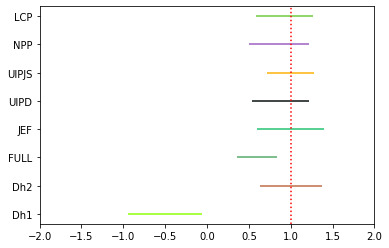

In [111]:
cols = list(sns.xkcd_rgb.values())
keys = []
plt.xlim([-2, 2])
for idx, key in enumerate(resCIs.keys()):
    keys.append(key)
    plt.hlines(idx, xmin=resCIs[key][0], xmax=resCIs[key][1], color=cols[idx])
plt.yticks(list(range(len(keys))), keys)
plt.axvline(theta0, linestyle=":", color="red")

In [107]:
ressave.append([resCIs, paras])

In [108]:
ressave

[[{'Dh1': array([-0.71954259, -0.27563739]),
   'Dh2': array([0.81583198, 1.18284622]),
   'FULL': array([-0.0416163 ,  0.23917973]),
   'JEF': array([-0.69587531, -0.3015041 ]),
   'UIPD': array([-0.61592526, -0.27578738]),
   'UIPJS': array([-0.64142682, -0.35572091]),
   'NPP': array([-0.62138535, -0.26700256]),
   'LCP': array([-0.64638992, -0.34737146])},
  {'sigma': 1, 'theta0': -0.5}],
 [{'Dh1': array([-0.72170559, -0.27683229]),
   'Dh2': array([0.81871586, 1.17719633]),
   'FULL': array([0.13139335, 0.40134283]),
   'JEF': array([-0.20045865,  0.19190351]),
   'UIPD': array([-0.19396278,  0.19257711]),
   'UIPJS': array([-0.26317933,  0.08972675]),
   'NPP': array([-0.1723941 ,  0.21167999]),
   'LCP': array([-0.24119588,  0.2538226 ])},
  {'sigma': 1, 'theta0': 0}],
 [{'Dh1': array([-0.72045016, -0.27644484]),
   'Dh2': array([0.81974122, 1.17603943]),
   'FULL': array([0.4621422 , 0.73535143]),
   'JEF': array([0.80197636, 1.19951123]),
   'UIPD': array([0.77565871, 1.118468

In [109]:
#with open("normCIs.pkl", "wb") as f:
#    pickle.dump(ressave, f)

In [3]:
with open("normCIs.pkl", "rb") as f:
    ressave = pickle.load(f)

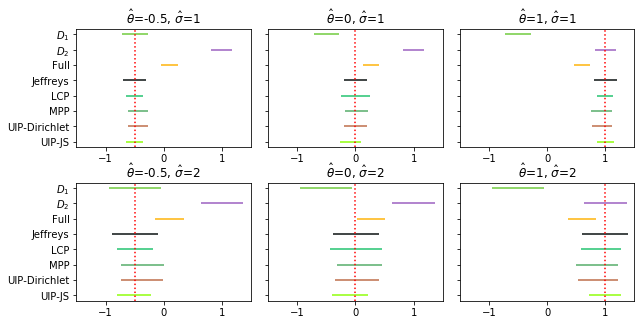

In [5]:
fig, axes = plt.subplots(nrows=2,ncols=3,
                         sharex=False,sharey=True, figsize=(10,5))
plt.subplots_adjust(wspace=0.1, hspace=0.3)
cols = list(sns.xkcd_rgb.values())
keys = ["UIP-JS", "UIP-Dirichlet", "MPP", "LCP", r"Jeffreys", "Full", r"$D_2$", r"$D_1$"]
ords = ["UIPJS", "UIPD", "NPP", "LCP", "JEF", "FULL", "Dh2", "Dh1"]
for i in range(2):
    for j in range(3):
        idx1 = i*3 + j
        resCIs, paras= ressave[idx1]
        axes[i, j].set_xlim([-1.5, 1.5])
        tl = r"$\hat{\theta}$" + f"={paras.theta0}" + ", " +  r"$\hat{\sigma}$" + f"={paras.sigma}"
        axes[i, j].set_title(tl)
        for idx, key in enumerate(ords):
            axes[i, j].hlines(idx, xmin=resCIs[key][0], xmax=resCIs[key][1], color=cols[idx])
        axes[i, j].axvline(paras.theta0, linestyle=":", color="red")
        axes[i, j].set_yticks(list(range(len(keys))))
        axes[i, j].set_yticklabels(keys)
plt.savefig("NormCIs.pdf")

<Figure size 432x288 with 0 Axes>